In [173]:
using Plots
using ForwardDiff
using ProgressMeter

In [174]:
function sample!(x,θ)
    T = size(θ,2) + 1
    for t = 1:T-1
        x[t+1] = x[t] + ( rand() < θ[x[t] + T, t] ? 1 : -1 )
    end
end

sample! (generic function with 1 method)

In [335]:
function logqt(x,θt,t)
    return log((x[t+1] - x[t]) == 1 ? θt[x[t] + T] : 1 - θt[x[t] + T])
end

function logQ(x,θ)
    T = size(θ,2) + 1
    s = 0
    for t = 1:T-1
        s += logqt(x,θ[:,t],t) 
    end
    return s
end

function isok(x)
    return   8 <= abs.(x[end]) <= 35
end

#=function logO(x,window)
    if  window[1] <= (x[end]) <= window[2]
        return 0
    elseif x[end] < window[1]
        return - (x[end] - window[1])^8 - 10
    elseif x[end] > window[2]
        return - abs(x[end] - window[2])^8 - 10
    end
end


function logO(x,window)
    if  window[1] <= abs.(x[end]) <= window[2]
        return 0
    else 
        return -15
    end
end=#


function logO(x,windows)
    a = 0
    for w in windows        
        if  !(w[2] <= (x[w[1]]) <= w[3])
            a -= 30
        end
    end
    return a
end

logO (generic function with 1 method)

In [336]:
function gradient!(dθ, x, θ)
    T = size(θ,2) + 1
    for t = 1:T-1
        ForwardDiff.gradient!((@view dθ[:,t]), θt -> logqt(x,θt,t), θ[:,t])
    end
end

gradient! (generic function with 1 method)

In [337]:
function impose_window!(θ,window)
    for x in 1:window[1]-1
        θ[x + T,T - window[1] + x] = 1
        θ[-x + T,T - window[1] + x] = 0
    end
    for x in 0:T-1-window[2]
        θ[- window[2] - x + T,T - x - 1] = 1
        θ[x + T + window[2],T - x - 1] = 0
    end
end

impose_window! (generic function with 1 method)

In [361]:
function descend!(θ, θp, θmin, θmax, windows; numsamples=10^4, numiters=100, η=0.1)
    N = size(θ,1)
    T = size(θ,2) + 1
    dθ = zero(θ)
    x = zeros(Int, T)
    pr = Progress(numiters) 
    avF = 0
    #impose_window!(θ,window)
    for it = 1:numiters
        avF = 0
        Dθ = zero(θ)
        for s = 1:numsamples
            sample!(x, θ)
            F = logQ(x,θ) - logQ(x,θp) - logO(x,windows)
            #F =  -logO(x,windows)
            avF += F / numsamples
            gradient!(dθ, x, θ)
            Dθ .+= F .* dθ ./ numsamples
        end
        θ .-= sign.(Dθ) .* η
        θ .= clamp.(θ, θmin, θmax)
        #impose_window!(θ,window)
        ProgressMeter.next!(pr, showvalues=[(:F,sum(avF))])
    end
    return avF
end

descend! (generic function with 1 method)

In [362]:
T = 40 #total time of movement
N = 2T - 1

θ = fill(1/2,N,T-1); 
#This is an N x T matrix where θ[i,t] represents 
#the probability of jumping to right at time t for particle i
#The prob of jumping to left is 1-θ[i,t]
dθ = fill(1/2,N,T-1); 

θp = fill(1/2,N,T-1); 

x = zeros(Int,T);

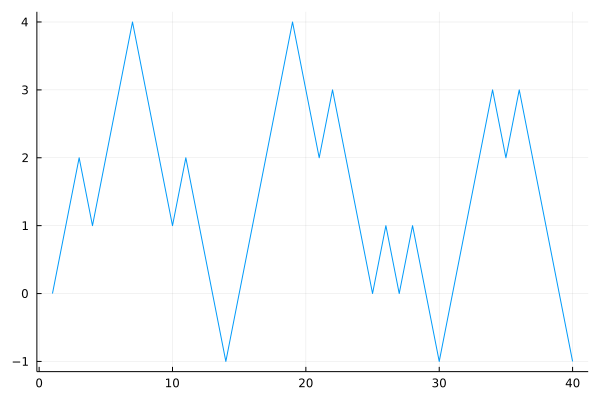

In [363]:
sample!(x,θp)
plot(x,legend=false)

In [364]:
windows = [(15,5,15),(35,-15,-7),(40,-3,1)]

3-element Vector{Tuple{Int64, Int64, Int64}}:
 (15, 5, 15)
 (35, -15, -7)
 (40, -3, 1)

In [365]:
T = 40 #total time of movement
N = 2T - 1
#windows = [(15,5,15),(35,-15,-7)]
#avF = descend!(θ, θp, 1e-4, 1-1e-4, windows; numsamples=1000, numiters=60, η=0.04)
windows = [(15,5,15),(35,-15,-7),(40,-3,1)]
avF = descend!(θ, θp, 1e-4, 1-1e-4, windows; numsamples=1000, numiters=40, η=0.1)
avF = descend!(θ, θp, 1e-4, 1-1e-4, windows; numsamples=1000, numiters=40, η=0.01)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/students/mmariani/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Progress:  22%|█████████▎                               |  ETA: 0:00:11
  F:  19.113235067798602

LoadError: InterruptException:

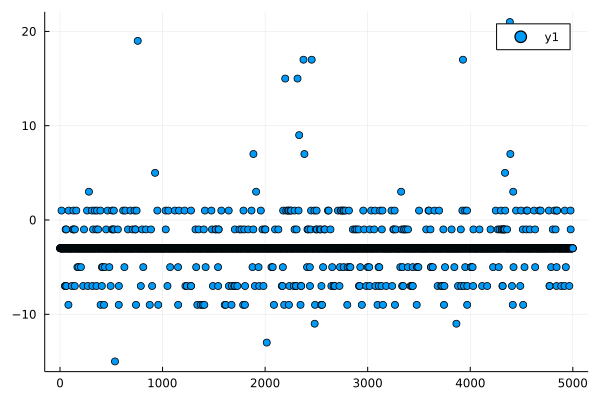

In [366]:
final_pt = zeros(5000)
p_sptime = zeros(N,T)
for st = 1:5000
    sample!(x,θ)
    #if x[end] > window[2]
     #   @show x
    #end
    for t in 1:T
        p_sptime[x[t] + T,t] += 1
    end
    final_pt[st] = x[end]
end
p_sptime ./= sum(p_sptime,dims=1)
scatter(final_pt)
#savefig("final_points.pdf")

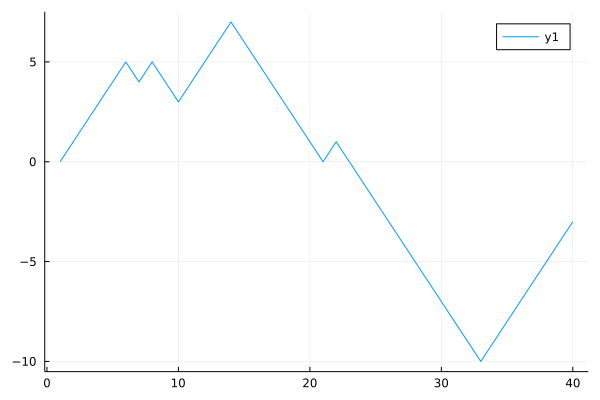

In [367]:
sample!(x,θ)
plot(x)

In [368]:
#plot1 libero
#plot2 in rosso quelle no in nero quelle si
#plot3 il marginale che già hai
#plot4 il marginale esatto (per me oer verifica)

Percentage of trajectories which satisfy the constraint: 88.8 %


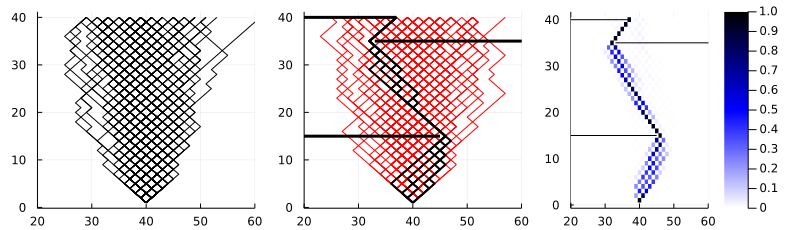

In [369]:
p1 = plot(x .+ T,1:T,c =:black,xlims=(20,60)) 
for st = 1:100
    sample!(x,θp)
    p1 = plot!(x .+ T,1:T,c =:black)
end

sample!(x,θp)
if logO(x,windows) == 0
    p2 = plot(x .+ T,1:T,c =:black,xlims=(20,60)) 
else
    p2 = plot(x .+ T,1:T,c =:red,xlims=(20,60))
end

for st = 1:100
    sample!(x,θp)
    if logO(x,windows) != 0
        p2 = plot!(x .+ T,1:T,c =:red,xlims=(20,60)) 
    end
end

for st = 1:1000000
    sample!(x,θp)
    if logO(x,windows) == 0
        p2 = plot!(x .+ T,1:T,c =:black,lw=2,xlims=(20,60)) 
    end
end


p2 = plot!((ones(N) .* windows[1][1])[1:windows[1][2]+T],c=:black,lw=3)
p2 = plot!(windows[2][3] +T:N,windows[2][1] .* ones(N-T-windows[2][3]+1),c=:black,lw=3)
p2 = plot!((ones(N) .* windows[3][1])[1:windows[3][2]+T],c=:black,legend=false,lw=3)

counter = 0
for st = 1:1000
    sample!(x,θ)
    if logO(x,windows) == 0
        counter += 1
    end
end

p3 = heatmap(1:N,1:T,(p_sptime)' ,c = [:white,:blue,:black])
p3 =plot!((ones(N) .* windows[1][1])[1:windows[1][2]+T],c=:black)
p3 =plot!(windows[2][3] +T:N,windows[2][1] .* ones(N-T-windows[2][3]+1),c=:black)
p3 =plot!((ones(N) .* windows[3][1])[1:windows[3][2]+T],c=:black,legend=false)

println("Percentage of trajectories which satisfy the constraint: $(counter/10) %")
plot(p1, p2, p3, size=(800,230), layout = (1, 3), legend = false,xlims=(20,60))

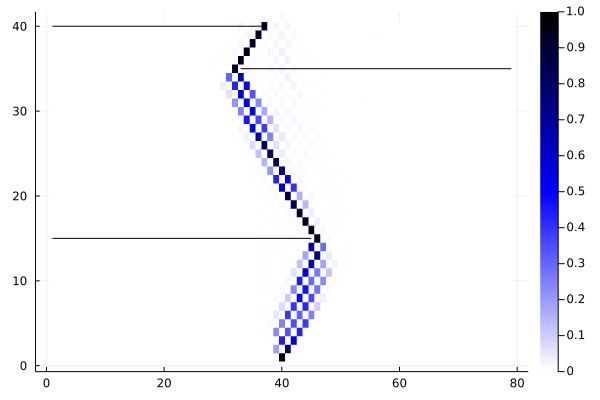

In [370]:
T = 40 #total time of movement
N = 2T - 1
cgrad(:matter)
Plots.heatmap(1:N,1:T,(p_sptime)' ,c = [:white,:blue,:black])
plot!((ones(N) .* windows[1][1])[1:windows[1][2]+T],c=:black)
plot!(windows[2][3] +T:N,windows[2][1] .* ones(N-T-windows[2][3]+1),c=:black)
plot!((ones(N) .* windows[3][1])[1:windows[3][2]+T],c=:black,legend=false)
#savefig("heatmap.png")

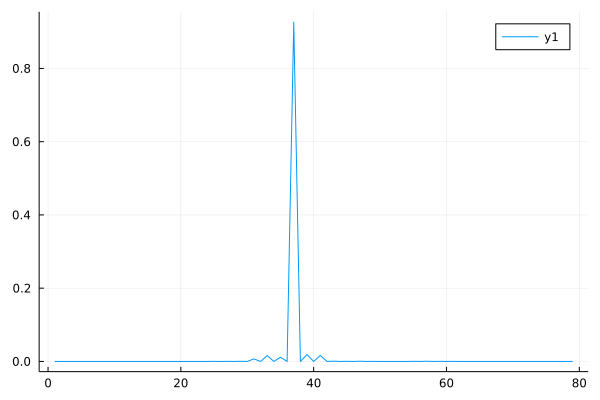

In [371]:
plot(p_sptime[:,end])

## Parameters of Causality

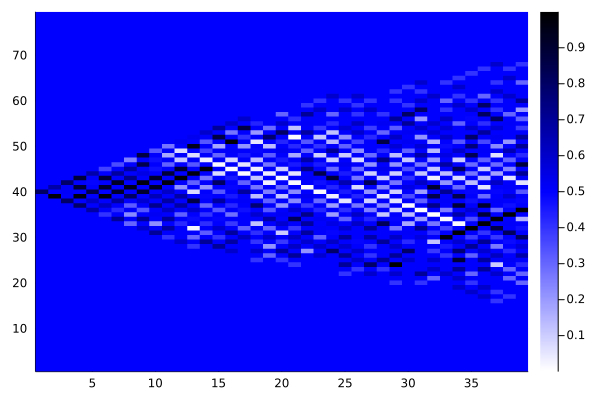

In [372]:
T = 40 #total time of movement
N = 2T - 1
cgrad(:matter)
Plots.heatmap(1:T-1,1:N,θ ,c = [:white,:blue,:black])

### A plot of trajectories over the parameters
we can see that many trajectories do not use many parameters which can consequently be considered as noise

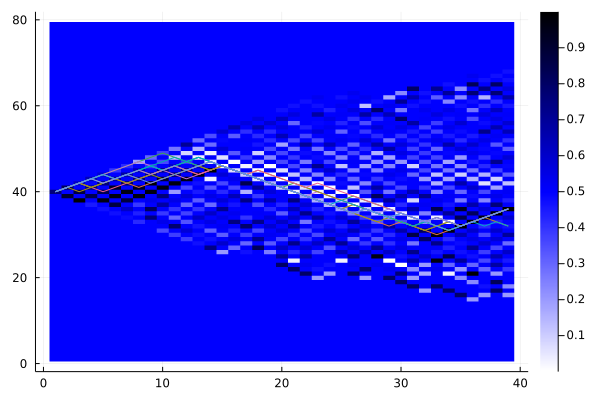

In [891]:
sample!(x,θ)
plot!(x[1:end-1] .+ T, legend = false)

### Parameters appering at least in the 0.5 percent of trajectories sampled
We select here only the parameters which have at least the 0.5 % of trajectories using them

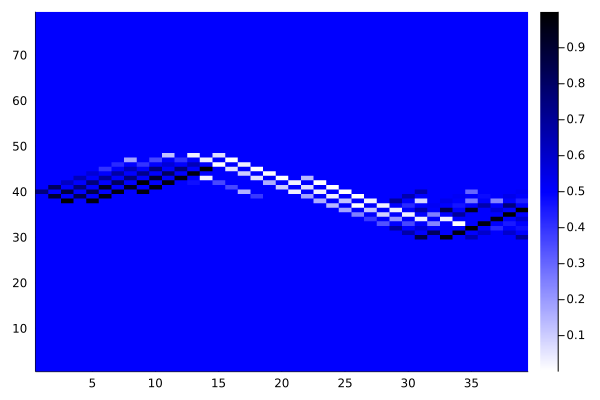

In [892]:
θfreq = 0.5 .+ zero(θ)
tot = 10000
for st = 1:tot
    sample!(x,θ)       
    for t=1:T-1
        θfreq[x[t] + T, t] += 1
    end
end
Plots.heatmap(1:T-1,1:N,((θfreq .> tot/200) .* θ) .+ ((θfreq .<= tot/200) .*  0.5) ,c = [:white,:blue,:black])
#savefig("heatmap.png")

### Parameters appearing only in trajectories which respect the hard constraint

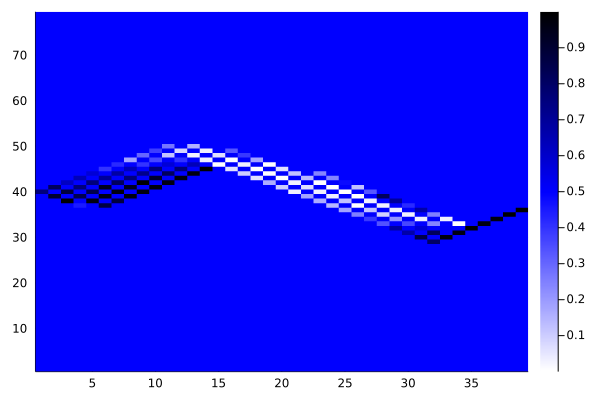

In [893]:
θfreq = 0.5 .+ zero(θ)
tot = 10000
for st = 1:tot
    sample!(x,θ) 
    if logO(x,windows) == 0              
        for t=1:T-1
            θfreq[x[t] + T, t] = θ[x[t] + T, t]
        end
    end
end
Plots.heatmap(1:T-1,1:N,θfreq ,c = [:white,:blue,:black])
#savefig("heatmap.png")

# Exact solution

# More Generalized exact solution

In [652]:
using LinearAlgebra, SparseArrays
A⊕B = kron(I(size(B,1)), A)+kron(B, I(size(A,1)))
lattice(n) = spdiagm(1=>trues(n-1),-1=>trues(n-1))
lattice(L...) = lattice(L[1])⊕lattice(L[2:end]...)
clattice(n) = (A=lattice(n); A[1,end]=A[end,1]=true; A)
clattice(L...) = clattice(L[1])⊕clattice(L[2:end]...)

clattice (generic function with 2 methods)

In [653]:
N = 80
T = 40
i0 = N÷2
A = 1.0*lattice(N);
A ./= sum(A, dims=1)

80×80 SparseMatrixCSC{Float64, Int64} with 6400 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿

In [660]:
function evolution(A,windows,t0,t,i0)
    C = I(size(A,1))
    for w in windows
        B = copy(A)
        B[1:w[2]-1+i0 ,:] .= 0
        B[w[3]+1+i0:end,:] .= 0
        C = A^(w[1]-1-t0) * C 
        C = B * C
        t0 = w[1]
    end
    return A^(t-t0) * C
    
end

function marginal(t,A,windows,T) 
    A1 = evolution(A,[w for w in windows if w[1] <= t],1,t,T) 
    A2 = evolution(A,[w for w in windows if w[1] > t],t,T,T)
    A3 = evolution(A,windows,1,T,T)
    return [sum(A2[:,i]) * A1[i,T] / sum(A3[:,T]) for i = 1:N]
end

marginal (generic function with 1 method)

In [666]:
T = 40
windows = [(15,5,15),(35,-15,-7),(40,-3,1)]

3-element Vector{Tuple{Int64, Int64, Int64}}:
 (15, 5, 15)
 (35, -15, -7)
 (40, -3, 1)

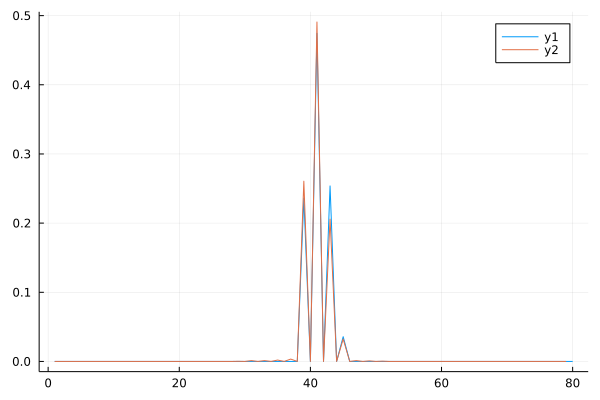

In [678]:
t = 22
plot(marginal(t,A,windows,T))
plot!(p_sptime[:,t] ./ sum(p_sptime[:,t]))

## 